Topic: Sparkify Analytics <br/>
Author: Chan Chee Kean <br/>
Date: 11 Oct 2020

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import calendar
sns.set(rc={'figure.figsize':(12,5)})
from statsmodels.tsa.filters.hp_filter import hpfilter
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Data Pre-Processing

In [2]:
data = pd.read_json('./data/sparkify_data.json', lines=True)

In [3]:
((data == '') | data.isnull()).sum()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


ts                    0
userId            15700
sessionId             0
page                  0
auth                  0
method                0
status                0
level                 0
itemInSession         0
location          15700
userAgent         15700
lastName          15700
firstName         15700
registration      15700
gender            15700
artist           110828
song             110828
length           110828
dtype: int64

<div class="alert alert-info"> 
    Null values should be only allowed for song, artist and length columns. 
    <br/> Drop row with unknown userId
</div>

In [4]:
# remove record without userId, add state, operating system
df = data[data['userId'] != ''].copy()
df['ts'] = pd.to_datetime(df['ts'] / 1000, unit='s')
df['registration'] = pd.to_datetime(df['registration'] / 1000, unit='s')
df['state'] = df['location'].str[-2:]
df['os'] = np.nan
for keyword in ['Mac', 'Windows', 'Linux']:
    df.loc[df['userAgent'].str.contains(keyword), 'os'] = keyword
df.drop(columns=['auth', 'method', 'userAgent', 'lastName', 'firstName', 'location'], inplace=True)
df.head()

,ts,userId,sessionId,page,status,level,itemInSession,registration,gender,artist,song,length,state,os
0,2018-10-01 00:00:11,293,292,NextSong,200,free,20,2018-07-20 05:11:47,M,Martin Orford,Grand Designs,597.55057,TX,Mac
1,2018-10-01 00:00:25,98,97,NextSong,200,free,74,2018-09-27 17:33:58,M,John Brown's Body,Bulls,380.21179,TX,Mac
2,2018-10-01 00:01:58,179,178,NextSong,200,paid,184,2018-09-03 05:44:15,M,Afroman,Because I Got High,202.37016,FL,Mac
3,2018-10-01 00:01:59,179,178,Logout,307,paid,185,2018-09-03 05:44:15,M,NaN,NaN,NaN,FL,Mac
4,2018-10-01 00:02:04,246,245,NextSong,200,paid,22,2018-09-02 23:30:18,F,Lily Allen,Smile (Radio Edit),194.53342,AL,Windows


In [5]:
print(f"Dataset ranged from\t {df['ts'].dt.date.min()} to {df['ts'].dt.date.max()}")
print(f"Number of users\t\t {df['userId'].nunique()}")
print(f"Number of artist\t {df['artist'].nunique()}")
print(f"Number of song\t\t {df['song'].nunique()}")
print(f"Maximum song length\t {df['length'].max()}")
print(f"Minimum song length\t {df['length'].min()}")

Dataset ranged from	 2018-10-01 to 2018-12-01
Number of users		 448
Number of artist	 21247
Number of song		 80292
Maximum song length	 3024.66567
Minimum song length	 0.78322


# Exploratory Analysis

## Timeseries Analysis

In [6]:
# usage is defined by 'Next Song' page, when user is listening to the song
df_usage = df[(df['page'] == 'NextSong') & (df['ts'].dt.month < 12)].copy()
df_usage['date'] = df['ts'].dt.date

Text(0.5, 0, 'Date')

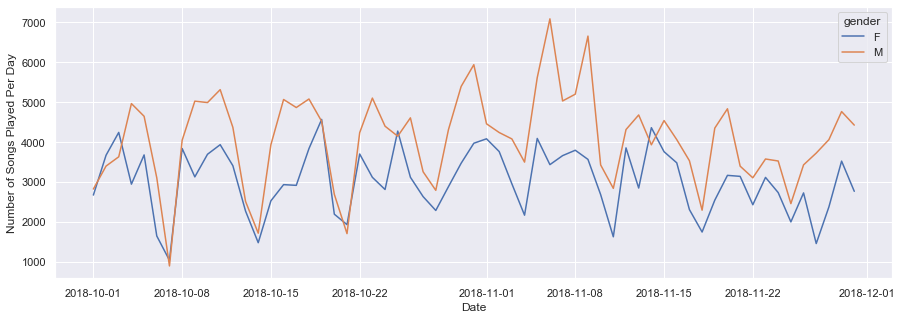

In [7]:
foo = df_usage.groupby([df_usage['ts'].dt.date, 'gender'])['userId'].count().unstack()
foo.plot(figsize=(15, 5))
plt.ylabel('Number of Songs Played Per Day')
plt.xlabel('Date')

<div class="alert alert-info"> 
    Seasonality observed.
</div>

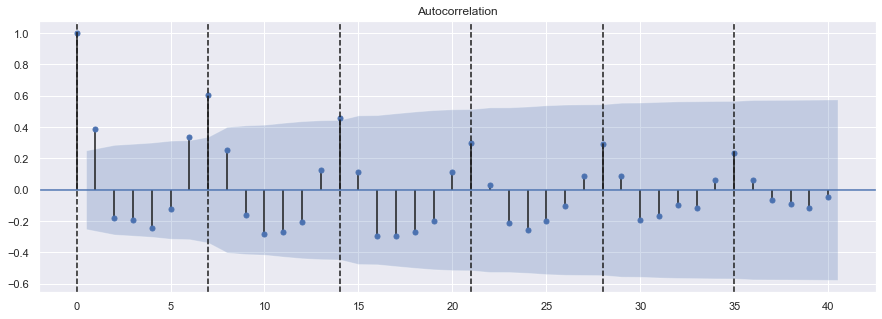

In [8]:
foo = df_usage.groupby([df_usage['ts'].dt.date])['userId'].count()
fig, ax = plt.subplots(figsize=(15, 5))
plot_acf(foo, lags=40, ax=ax);
for x in np.arange(0, 40, 7):
    plt.axvline(x=x, color='k', linestyle='--')

<div class="alert alert-info"> 
    Visually this shows evidence of a very strong autocorrelation between the lagged values of 7 days
</div>

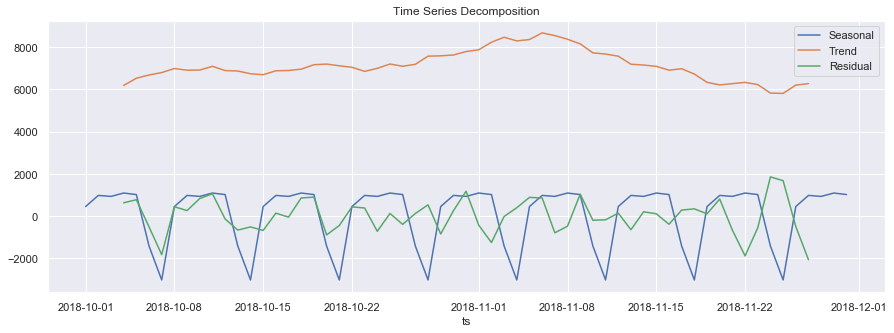

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.title('Time Series Decomposition')
seasonal_decompose(foo, period=7).seasonal.plot(label='Seasonal')
seasonal_decompose(foo, period=7).trend.plot(label='Trend')
seasonal_decompose(foo, period=7).resid.plot(label='Residual')
plt.legend();

<div class="alert alert-info"> 
    Time Series Decomposition: <br/>
    y(t) = Trend + Seasonality + Noise</div>    
</div>

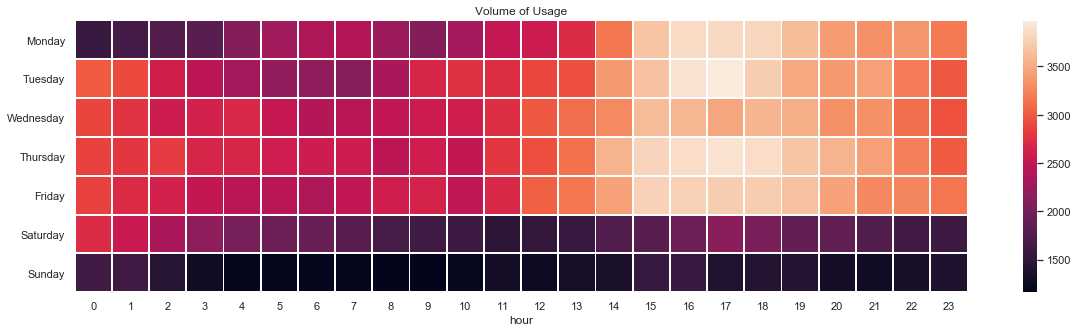

In [10]:
foo = df_usage.copy()
foo['day'] = foo['ts'].dt.weekday
foo['hour'] = foo['ts'].dt.hour.values
bar = foo.groupby(['day', 'hour'])['userId'].count().unstack()
bar.index = [calendar.day_name[x] for x in bar.index]
fig, ax = plt.subplots(figsize=(20, 5))
plt.title("Volume of Usage")
sns.heatmap(bar, linewidths=1);

<div class="alert alert-info"> 
    Certainly there are higher volume of usage at certain timing and days.  
</div>

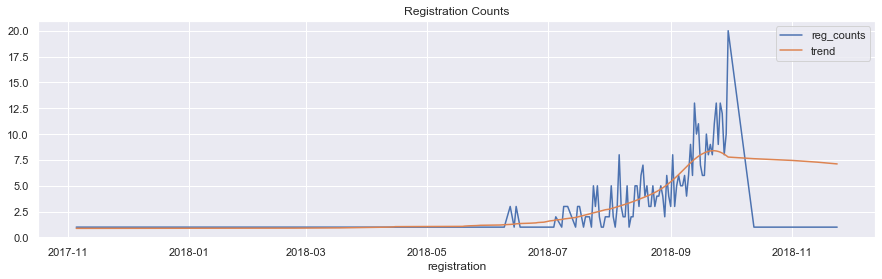

In [11]:
foo = df.groupby(df['registration'].dt.date)['userId'].nunique().reset_index(name='reg_counts')
foo['trend'] = hpfilter(foo['reg_counts'], lamb=4800)[1]
foo.set_index('registration', inplace=True)
foo.plot(figsize=(15, 4))
plt.title('Registration Counts');

<div class="alert alert-info"> 
The Hodrick-Prescott filter</a> separates a time-series  $y_t$ into a trend component $\tau_t$ and a cyclical component $c_t$
<br/>$y_t = \tau_t + c_t$

</div>

## Comparative Analysis

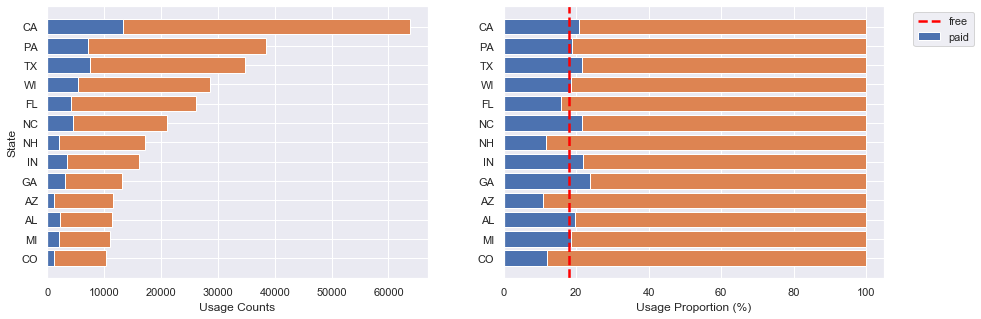

In [12]:
foo = df_usage.groupby(['state', 'level'])['userId'].count().unstack()
foo['sum'] = foo.sum(axis=1)
foo = foo[foo['sum'] > 10000]
foo = foo.sort_values('sum').drop(columns='sum')

# left plot
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].barh(foo.index, foo['free'])
axes[0].barh(foo.index, foo['paid'], left = foo['free'])
axes[0].set_xlabel('Usage Counts')
axes[0].set_ylabel('State')

# right plot
foo = foo.divide(foo.sum(axis=1), axis=0) * 100
axes[1].barh(foo.index, foo['free'])
axes[1].barh(foo.index, foo['paid'], left = foo['free'])
axes[1].axvline(x=foo['free'].mean(), color='red', linestyle='--', lw=2.5)
axes[1].set_xlabel('Usage Proportion (%)')
axes[1].legend(list(foo.columns), bbox_to_anchor=(0.75, 0, 0.5, 1));

<div class="alert alert-info"> 
    CA state have the highest volume of usage, followed by PA, TX, WI...
    <br/> CA, PA, TX, IN, GA and AL are having higher free usage proportion that above average level
</div>

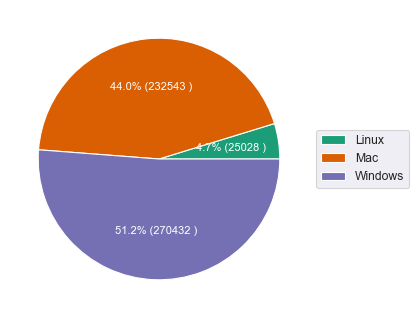

In [13]:
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:d} )".format(pct, absolute)

foo = df.groupby(['os'])['userId'].count().reset_index(name='counts')
fig, ax = plt.subplots(figsize=(15, 5), subplot_kw=dict(aspect="equal"), dpi= 80)
_data = foo['counts']
categories = foo['os']

wedges, texts, autotexts = ax.pie(_data,
                                  autopct=lambda pct: func(pct, _data),
                                  textprops=dict(color="w"), 
                                  colors=plt.cm.Dark2.colors
                                 )

ax.legend(wedges, categories, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=10, weight=500);

<div class="alert alert-info"> 
    Windows Users have the highest usage volume followed by Mac and Linux users.
</div>

10th Percentile:	 29.40 minutes
25th Percentile:	 80.28 minutes
50th Percentile:	 203.13 minutes
75th Percentile:	 434.21 minutes
95th Percentile:	 919.56 minutes


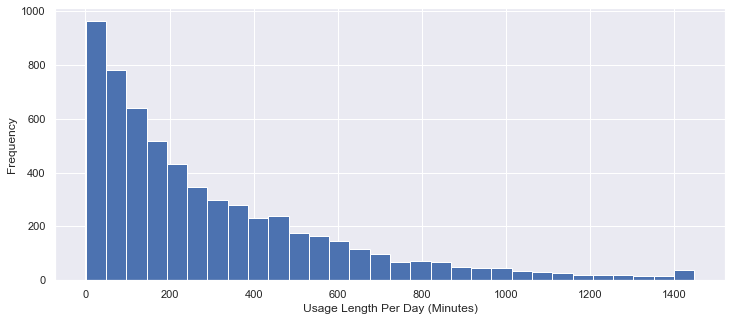

In [14]:
foo = df_usage.groupby([df_usage['ts'].dt.date, 'userId'])['length'].sum().reset_index()

for q in [0.10, 0.25, 0.50, 0.75, 0.95]:
    print(f"{int(q*100)}th Percentile:\t {foo['length'].quantile(q) / 60:0.2f} minutes")

(foo['length'] / 60).plot.hist(bins=30)
plt.xlabel("Usage Length Per Day (Minutes)");

<div class="alert alert-info"> 
    Majority of the users are listening >3 hours a day
</div>

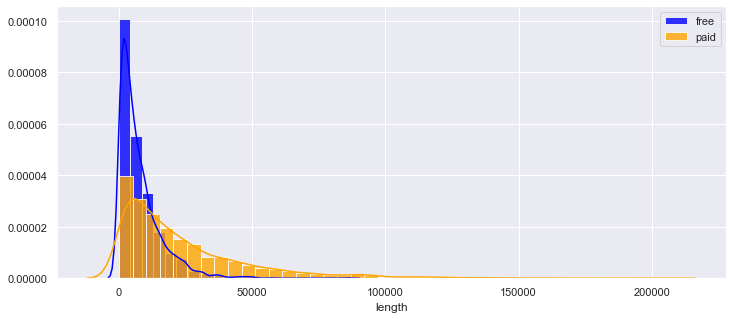

In [15]:
foo = df_usage.groupby(['level', 'userId', 'sessionId'])['length'].sum().reset_index()
sns.distplot(foo[foo['level'] == 'free']['length'], color="blue", bins=20, hist_kws={'alpha':.8}, label='free')
sns.distplot(foo[foo['level'] == 'paid']['length'], color="orange", bins=40, hist_kws={'alpha':.8}, label='paid');
plt.legend();

<div class="alert alert-info"> 
    The chart reflected the variation in distribution of "Usage Length per Session" for free and paid users. <br/>
    They possess different values for measures of centre, kurtosis and skewness. <br/>
    The shift of distribution indicates usage length is a contributing factor for upgrading.
</div>

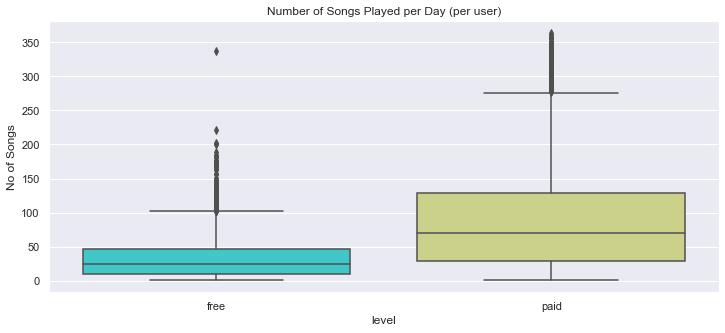

In [16]:
foo = df_usage.groupby(['level', 'userId', df_usage['ts'].dt.date])['length'].count().reset_index(name='counts')

sns.boxplot(x='level', y='counts', data=foo, palette='rainbow');
plt.ylabel('No of Songs');
plt.title('Number of Songs Played per Day (per user)');

<div class="alert alert-info"> 
    Evidently, paid users played more song per day than free user
</div>

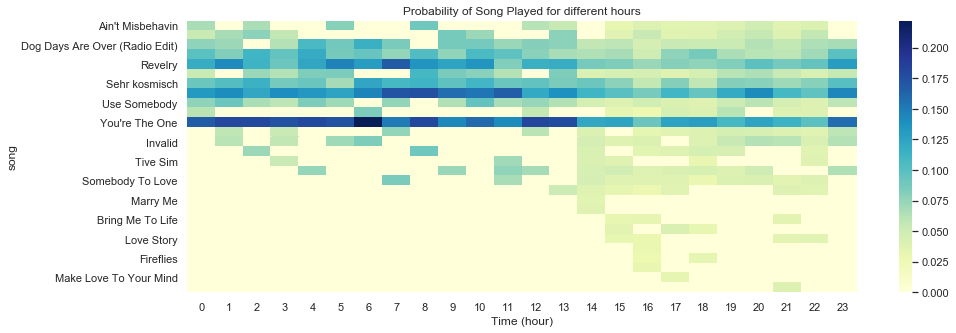

In [17]:
foo = df_usage.groupby([df_usage['ts'].dt.hour, 'song'])['userId'].count()
foo = foo[foo > 30].unstack().fillna(0)
foo = foo.divide(foo.sum(axis=1), axis=0)
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(foo.T, cmap="YlGnBu");
plt.xlabel("Time (hour)");
plt.title('Probability of Song Played for different hours');

<div class="alert alert-info"> 
    Some songs are only favoured by the users at particular timing. <br/>
    This data is useful for radio broadcast and recommendation system
</div>

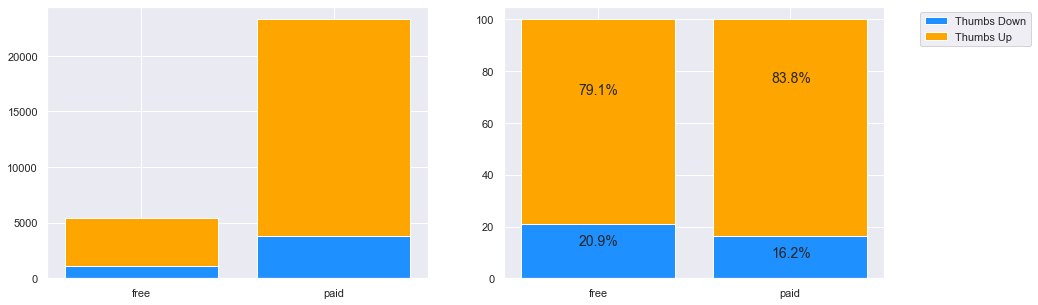

In [18]:
df_thumbs = df[df['page'].isin(['Thumbs Down', 'Thumbs Up'])].copy()
foo = df_thumbs.groupby(['level' ,'page'])['ts'].count().unstack()

# left plot
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].bar(foo.index, foo['Thumbs Down'], color='dodgerblue')
axes[0].bar(foo.index, foo['Thumbs Up'], bottom = foo['Thumbs Down'], color='orange')

# right plot
foo = foo.divide(foo.sum(axis=1), axis=0) * 100
axes[1].bar(foo.index, foo['Thumbs Down'], color='dodgerblue')
axes[1].bar(foo.index, foo['Thumbs Up'], bottom = foo['Thumbs Down'], color='orange')
axes[1].legend(list(foo.columns), bbox_to_anchor=(0.9, 0, 0.5, 1));

for i in axes[1].patches:
    axes[1].text(i.get_x() + 0.3, i.get_height() - 8, str(round(i.get_height(), 1)) + '%', fontsize=14)

## User Based Analysis

In [19]:
def insert_feature(df_temp, 
                   avg_time=True, 
                   active=True, 
                   session_len=True, 
                   num_logout=True,
                   playlist_len=True, 
                   friend_count=True, 
                   level=True, 
                   thumbs_count=True, 
                   churn=True):
    
    if avg_time:
        # average spending time per day
        _length = df_usage.groupby(['userId'])['length'].sum() / 60
        df_temp = df_temp.merge((df_usage.groupby(['userId'])['length'].sum() / 60).reset_index(name='avg_day_length'))
        df_temp['avg_day_length'] = df_temp['avg_day_length'] / df_temp['data_days']
    
    if active:
        # percentage of a active days
        df_temp = df_temp.merge((df_usage.groupby('userId')['date'].nunique() - 1).reset_index(name='active_p'))
        df_temp['active_p'] = df_temp['active_p'] / df_temp['data_days']
    
    if session_len:
        # length per session
        _session = df_usage.groupby(['userId', 'sessionId'])['length'].sum().unstack() / 60
        df_temp = df_temp.merge(_session.mean(axis=1).reset_index(name='avg_session_length'))
    
    if num_logout:
        # number of logout
        _logout = df.query("page == 'Logout'").groupby('userId')['ts'].count().reset_index(name='logout_count')
        df_temp = df_temp.merge(_logout, how='left')
    
    if playlist_len:
        # playlist length
        _playlist = df.query("page == 'Add to Playlist'").groupby('userId')['ts'].count().reset_index(name='playlist_count')
        df_temp = df_temp.merge(_playlist, how='left')
    
    if friend_count:
        # friend count
        _friend = df.query("page == 'Add Friend'").groupby('userId')['ts'].count().reset_index(name='friend_count')
        df_temp = df_temp.merge(_friend, how='left')
    
    if level:
        # level
        _level = df.groupby(['userId', 'level'])['ts'].count().unstack().fillna(0)
        _level  = (_level > 0).astype(int)
        df_temp = df_temp.merge(_level.reset_index(), how='left')
    
    if thumbs_count:
        # thumbs count
        _thumb = df_thumbs.groupby(['userId', 'page'])['ts'].count().unstack().reset_index()
        df_temp = df_temp.merge(_thumb, how='left')

    # churn
    if churn:
        _churn = df.query("page == 'Cancellation Confirmation'").groupby('userId')['ts'].count().reset_index(name='churn')
        df_temp = df_temp.merge(_churn, how='left')
        df_temp = df_temp.fillna(0)
    
    return df_temp

In [20]:
df_user = df.groupby('userId')[['registration', 'ts', 'gender', 'os', 'state']].last().reset_index()
df_user.columns = ['userId', 'reg_date', 'last_date', 'gender', 'os', 'state']
df_user['reg_dur'] = (df_user['last_date'] - df_user['reg_date']).dt.days
df_user['data_days'] = (df_user['last_date'] - df.ts.min()).dt.days
df_user = df_user[(df_user['data_days'] > 0) & (df_user['reg_dur'] > 0)]

df_user = insert_feature(df_user)
df_user.drop(columns=['reg_date', 'last_date', 'data_days'], inplace=True)
df_user.head()

,userId,gender,os,state,reg_dur,avg_day_length,active_p,avg_session_length,logout_count,playlist_count,friend_count,free,paid,Thumbs Down,Thumbs Up,churn
0,10,M,Mac,MS,10,188.592585,0.125000,1508.740679,4.0,14.0,3.0,0,1,1.0,17.0,1.0
1,100,M,Windows,TX,65,230.485648,0.583333,354.593304,36.0,94.0,71.0,1,1,37.0,143.0,0.0
2,100001,F,Mac,FL,44,396.588988,1.000000,132.196329,2.0,3.0,1.0,1,0,1.0,5.0,1.0
3,100002,F,Windows,CA,129,19.150553,0.093750,153.204421,3.0,3.0,0.0,1,1,2.0,8.0,0.0
4,100003,F,Windows,FL,50,71.180987,0.236842,338.109689,12.0,19.0,8.0,1,1,10.0,16.0,1.0


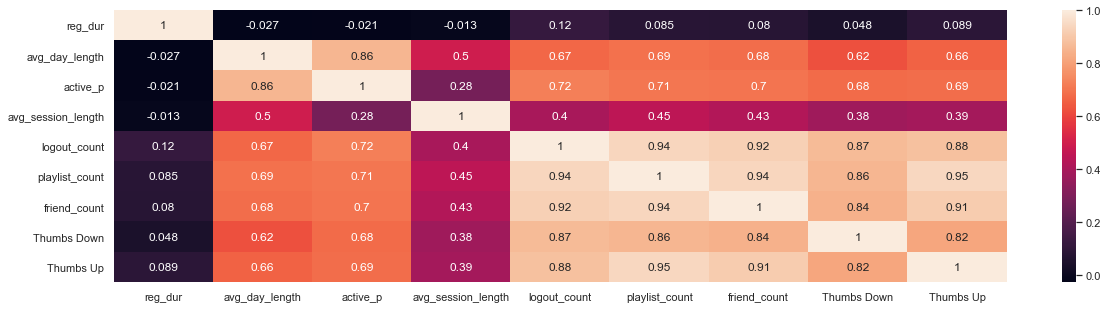

In [21]:
corr = df_user[['reg_dur', 'avg_day_length', 'active_p', 'avg_session_length', 'logout_count', 
                'playlist_count', 'friend_count', 'Thumbs Down', 'Thumbs Up']].corr()
plt.figure(figsize=(20,5))
# plot heat map
g = sns.heatmap(corr, annot=True)

<div class="alert alert-info"> 
    logout count, playlist count, friend count, thumbs down and thumbs up count are highly correlated to each other
</div>

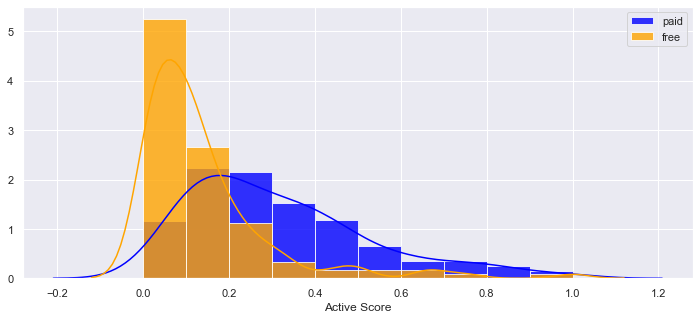

In [22]:
foo = df_user.groupby(['paid', 'userId'])['active_p'].sum().reset_index()
sns.distplot(foo[foo['paid'] == 1]['active_p'], color="blue", bins=10, hist_kws={'alpha':.8}, label='paid')
sns.distplot(foo[foo['paid'] == 0]['active_p'], color="orange", bins=10, hist_kws={'alpha':.8}, label='free')
plt.xlabel('Active Score')
plt.legend();

<div class="alert alert-info"> 
    Free Users are less active than paid users. <br/>
    Yet, there are outliers in free users who have high level of activity
</div>

# Churn Predictions

## Data Processing

In [23]:
df_user['free'] = 1 - df_user['paid']
df_user = pd.concat([df_user, pd.get_dummies(df_user['os'], drop_first=True)], axis=1)
df_user = pd.concat([df_user, pd.get_dummies(df_user['state'], drop_first=True)], axis=1)
df_user['gender'] = [1 if x == 'M'  else 0 for x in df_user['gender']]
df_user.drop(columns=['userId', 'os', 'state'], inplace=True)

## Feature Importance

In [24]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier

### Chi Square

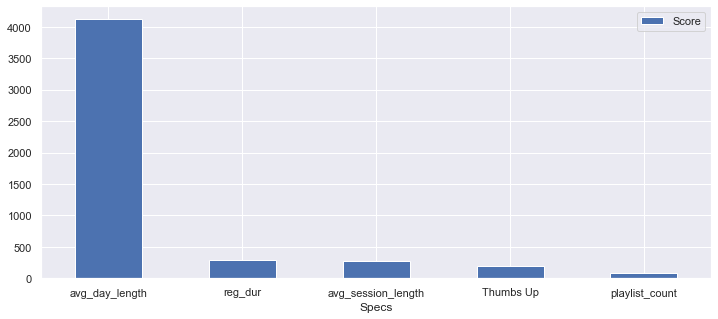

In [25]:
# SelectKBest class to extract top 10 best features 
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(df_user.drop(columns='churn').values, df_user['churn'])
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(df_user.drop(columns='churn').columns)

# concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score'] #naming the dataframe columns
featureScores.nlargest(5, 'Score').set_index('Specs').plot(kind='bar')
plt.xticks(rotation=0);

### Tree Based

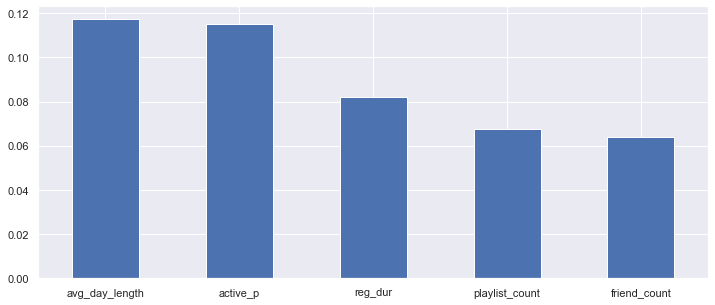

In [26]:
model = ExtraTreesClassifier()
model.fit(df_user.drop(columns='churn').values, df_user['churn'])
feat_importances = pd.Series(model.feature_importances_, index=df_user.drop(columns='churn').columns)
feat_importances.nlargest(5).plot(kind='bar')
plt.xticks(rotation=0);

### Recursive Feature Elimination

In [27]:
num = 5
rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=num)
rfe.fit(df_user.drop(columns='churn').values, df_user['churn'])
print(f'Best {num} features: {df_user.drop(columns=["churn"]).columns[rfe.support_].values}')

Best 5 features: ['reg_dur' 'avg_day_length' 'active_p' 'playlist_count' 'Thumbs Up']


<div class="alert alert-info"> 
Following features are having high influence on the churn probability: <br/>
<b>'reg_dur', 'avg_day_length', 'active_p', 'playlist_count', 'Thumbs Up', 'avg_session_length'</b>
</div>

## Outlier Detection

In [28]:
from sklearn.neighbors import LocalOutlierFactor

In [29]:
X, y = df_user.drop(columns='churn'), df_user['churn']
ifo = LocalOutlierFactor(10, p=1, contamination=0.10, n_jobs=-1)
lof_mask = ifo.fit_predict(X)
df_out = df_user.loc[lof_mask != 1]
print(f"Number of Outliers: {df_out.shape[0]}")
print(f"Number of Churn: {df_out[df_out['churn'] == 1].shape[0]}")

Number of Outliers: 45
Number of Churn: 28


<div class="alert alert-info"> 
Out of 45 outliers (10 % of total data), 28 are Churns (62%)
</div>

## Model Building

In [30]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, confusion_matrix,  classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [31]:
cols = ['reg_dur', 'avg_day_length', 'active_p', 'playlist_count', 'Thumbs Up', 'avg_session_length']
X, y = df_user[cols], df_user['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [32]:
# applying GridSearch to find the best parameters
lg = lgb.LGBMClassifier(silent=False)
param_dist = {"max_depth": [10, 25, 50, 100],
              "learning_rate" : [0.005, 0.01, 0.05, 0.1],
              "num_leaves": [100, 300, 500],
              "n_estimators": [100, 200, 300]
             }

grid_search = GridSearchCV(lg, n_jobs=-1, param_grid=param_dist, cv=3, scoring="roc_auc", verbose=0)
grid_search.fit(X_train,y_train)
print(grid_search.best_estimator_)

LGBMClassifier(learning_rate=0.05, max_depth=10, n_estimators=200,
               num_leaves=100, silent=False)


In [33]:
# model fitting
d_train = lgb.Dataset(X_train, label=y_train)
params = {"max_depth": 10, "learning_rate" : 0.05, "num_leaves": 100,  "n_estimators": 200}
# Without Categorical Features
clf_lgb = lgb.train(params, d_train)

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [34]:
# prediction and evaluation
predictions = clf_lgb.predict(X_test)
y_pred = (predictions > 0.5) * 1
cm = confusion_matrix(y_test, y_pred)
print(pd.DataFrame(cm, columns = ['Predicted -', 'Predicted +'], index = ['Actual -', 'Actual +']))
print(classification_report(y_test,y_pred))

          Predicted -  Predicted +
Actual -           67            3
Actual +            4           15
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95        70
         1.0       0.83      0.79      0.81        19

    accuracy                           0.92        89
   macro avg       0.89      0.87      0.88        89
weighted avg       0.92      0.92      0.92        89



<div class="alert alert-info"> 
    Further feature selections can be performed for example: <br/>
    Backward elimination, Recursive Forward Selection, Base Model Comparison
</div>

The End